In [38]:
import numpy as np
import sympy as sp
from scipy.special import jn
from scipy.linalg import expm, logm
import qutip as qt
import matplotlib.pyplot as plt
from matplotlib import cbook
import psutil
import time

# Quantum optimal control with matrix product operators

## Create the MPOs

In [100]:
# Pauli Z matrix
sigma_z = np.array([[1.0+0*1j, 0], [0, -1]])

# Identity matrix
I = np.eye(2)

def create_H0_mpo(N, J):
    """
    Creates the MPO for H0 = sum_i J sigma_i^z sigma_{i+1}^z

    Parameters:
        N (int): Number of qubits
        J: Coefficient of J

    Returns:
        list of np.ndarray: MPO tensors for H0
    """
    
    mpo = []
    for i in range(N):

        if i == 0:
            # First tensor
            tensor = np.zeros((1, 3, 2, 2), dtype=object)  # Bond dimension r=2
            tensor[0,0, :, :] = 0
            tensor[0,1, :, :] = J * sigma_z
            tensor[0,2, :, :] = I
        elif i == N - 1:
            # Last tensor
            tensor = np.zeros((3, 1, 2, 2), dtype=object)  # Bond dimension r=2
            tensor[0,0, :, :] = I
            tensor[1,0, :, :] = J * sigma_z
            tensor[2,0, :, :] = 0
        else:
            # Middle tensors
            tensor = np.zeros((3, 3, 2, 2), dtype=object)  # Bond dimension r=2
            tensor[0,0, :, :] = I
            tensor[1,0, :, :] = sigma_z
            tensor[2,1, :, :] = J * sigma_z
            tensor[2,2, :, :] = I
        mpo.append(tensor)
        
    return mpo

In [101]:
# Pauli X matrix
sigma_x = np.array([[0, 1.0], [1.0, 0]])

def create_Hc_mpo(N):
    """
    Creates the MPO for Hc = sum_i sigma_i^x

    Parameters:
        N (int): Number of qubits

    Returns:
        list of np.ndarray: MPO tensors for Hc
    """
    
    mpo = []
    for i in range(N):

        if i == 0:
            # First tensor
            tensor = np.zeros((1, 2, 2, 2), dtype=object)  # Bond dimension r=2
            tensor[0,0, :, :] = I
            tensor[0,1, :, :] = sigma_x
        elif i == N - 1:
            # Last tensor
            tensor = np.zeros((2, 1, 2, 2), dtype=object)  # Bond dimension r=2
            tensor[0,0, :, :] = sigma_x
            tensor[1,0, :, :] = I
        else:
            # Middle tensors
            tensor = np.zeros((2, 2, 2, 2), dtype=object)  # Bond dimension r=2
            tensor[0,0, :, :] = I
            tensor[0,1, :, :] = sigma_x
            tensor[1,1, :, :] = I
        mpo.append(tensor)
        
    return mpo

In [102]:
def create_I_mpo(N):

    """
    Creates the MPO for the identity

    Parameters:
        N (int): Number of qubits

    Returns:
        list of np.ndarray: MPO tensors for I
    """

    mpo = []
    for i in range(N):
        tensor = np.zeros((1, 1, 2, 2), dtype=object)  # Bond dimension r=1
        tensor[0,0, :, :] = I
        mpo.append(tensor)

    return mpo
        

## Define the functions to operate with MPOs 

In [103]:
def add(mpo1,mpo2):

    """
    Adds two MPOs

    Parameters:
        mpo1: first MPO
        mpo2: second MPO

    Returns:
        list of np.ndarray: MPO tensors for the sum mpo1+mpo2
    """

    ## Check MPOs have the same number of tensors (live in the same dimension)
    assert len(mpo1) == len(mpo2)

    ## We start by creating an empty list of tensors with adequate dimensions
    new_mpo = []

    ## First we add the empty first boundary to the new list of core tensors
    new_mpo.append(np.zeros((1,mpo1[0].shape[1]+mpo2[0].shape[1],2,2), dtype=object))

    ## Add the rectangular tensors in the center
    if len(mpo1)>2:
        for i in range(1,len(mpo1)-1):
            new_mpo.append(np.zeros((mpo1[i].shape[0]+mpo2[i].shape[0],mpo1[i].shape[1]+mpo2[i].shape[1],2,2), dtype=object))

    ## Add the last ending boundary of the list of tensors
    new_mpo.append(np.zeros((mpo1[len(mpo1)-1].shape[0]+mpo2[len(mpo2)-1].shape[0],1,2,2), dtype=object))

    ## Compute the summed tensors for the boundaries
    for j in range(mpo1[0].shape[1]):
        new_mpo[0][0,j,:,:] = mpo1[0][0,j,:,:]
    for k in range(mpo2[0].shape[1]):
        new_mpo[0][0,mpo1[0].shape[1]+k,:,:] = mpo2[0][0,k,:,:]

    for j in range(mpo1[len(mpo1)-1].shape[0]):
        new_mpo[len(mpo1)-1][j,0,:,:] = mpo1[len(mpo1)-1][j,0,:,:]
    for k in range(mpo2[len(mpo2)-1].shape[0]):
        new_mpo[len(mpo2)-1][mpo1[len(mpo1)-1].shape[0]+k,0,:,:] = mpo2[len(mpo2)-1][k,0,:,:]

    ## Now the summed central tensors
    if len(mpo1)>2:
        for i in range(1,len(mpo1)-1):
            for j in range(mpo1[i].shape[0]):
                for k in range(mpo1[i].shape[1]):
                    new_mpo[i][j,k,:,:] = mpo1[i][j,k,:,:]
    
            for j in range(mpo2[i].shape[0]):
                    for k in range(mpo2[i].shape[1]):
                        new_mpo[i][mpo1[i].shape[0]+j,mpo1[i].shape[1]+k,:,:] = mpo2[i][j,k,:,:]
    
    return new_mpo

In [104]:
def prod_scalar(mpo, c):

    """
    Takes the product of an MPO with a scalar

    Parameters:
        mpo: MPO
        c: scalar

    Returns:
        list of np.ndarray: MPO tensors for the product cMPO
    """
    new_mpo = [np.copy(tensor) for tensor in mpo]  # Make a deep copy
    for i in range(new_mpo[0].shape[0]):
        for j in range(new_mpo[0].shape[1]):
            for k in range(new_mpo[0].shape[2]):
                for l in range(new_mpo[0].shape[3]):
                    new_mpo[0][i, j, k, l] *= c
    return new_mpo

In [105]:
def prod(mpo1,mpo2):

    """
    Mulitplies two MPOs

    Parameters:
        mpo1: first MPO
        mpo2: second MPO

    Returns:
        list of np.ndarray: MPO tensors for the product (mpo1)(mpo2)
    """

    ## Check MPOs have the same number of tensors (live in the same dimension)
    assert len(mpo1) == len(mpo2)

    ## We start by creating an empty list of tensors with adequate dimensions
    new_mpo = []

    ## First we add the empty first boundary to the new list of core tensors
    new_mpo.append(np.zeros((1,mpo1[0].shape[1]*mpo2[0].shape[1],2,2), dtype=object))

    ## Add the rectangular tensors in the center
    if len(mpo1)>2:
        for i in range(1,len(mpo1)-1):
            new_mpo.append(np.zeros((mpo1[i].shape[0]*mpo2[i].shape[0],mpo1[i].shape[1]*mpo2[i].shape[1],2,2), dtype=object))

    ## Add the last ending boundary of the list of tensors
    new_mpo.append(np.zeros((mpo1[len(mpo1)-1].shape[0]*mpo2[len(mpo2)-1].shape[0],1,2,2), dtype=object))

    ## Compute the tensors for the boundaries
    for j in range(mpo1[0].shape[1]):
        for k in range(mpo2[0].shape[1]):
            new_mpo[0][0,k+j*(mpo2[0].shape[1]),:,:] = np.outer(mpo1[0][0,j,:,0],mpo2[0][0,k,0,:])+np.outer(mpo1[0][0,j,:,1],mpo2[0][0,k,1,:])

    for j in range(mpo1[len(mpo1)-1].shape[0]):
        for k in range(mpo2[len(mpo2)-1].shape[0]):
            new_mpo[len(mpo1)-1][k+j*(mpo2[len(mpo2)-1].shape[0]),0,:,:] = np.outer(mpo1[len(mpo1)-1][j,0,:,0],mpo2[len(mpo2)-1][k,0,0,:])+np.outer(mpo1[len(mpo1)-1][j,0,:,1],mpo2[len(mpo2)-1][k,0,1,:])


    ## Now we compute the values of the intermediate tensor cores
    if len(mpo1)>2:
        ## For each core tensor
        for i in range(1,len(mpo1)-1):
            ## Take each element of the first tensor
            for j in range(mpo1[i].shape[0]):
                for k in range(mpo1[i].shape[1]):

                    ## Compute with all the elements of the equivalent tensor in second mpo
                    for s in range(mpo2[i].shape[0]):
                        for t in range(mpo2[i].shape[1]):
                            new_mpo[i][s+j*(mpo2[i].shape[1]),t+k*(mpo2[i].shape[1]),:,:] = np.outer(mpo1[i][j,k,:,0],mpo2[i][s,t,0,:])+np.outer(mpo1[i][j,k,:,1],mpo2[i][s,t,1,:])

    return new_mpo

In [106]:
def trace_mpo(mpo1):

    """
    Computes the trace of an MPO efficiently

    Parameters:
        mpo1: MPO

    Returns:
        float, the trace of mpo1
    """

    mat = []

    ## First we add the empty first boundary to the new list of core tensors
    mat.append(np.zeros((1,mpo1[0].shape[1]), dtype=object))

    ## Add the rectangular tensors in the center
    if len(mpo1)>2:
        for i in range(1,len(mpo1)-1):
            mat.append(np.zeros((mpo1[i].shape[0],mpo1[i].shape[1]), dtype=object))

    ## Add the last ending boundary of the list of tensors
    mat.append(np.zeros((mpo1[len(mpo1)-1].shape[0],1), dtype=object))

    for i in range(2):
        for j in range(mpo1[0].shape[1]):
            mat[0][0,j] = mat[0][0,j] + mpo1[0][0,j,i,i]

    for i in range(2):
        for j in range(mpo1[len(mpo1)-1].shape[0]):
            mat[len(mpo1)-1][j,0] = mat[len(mpo1)-1][j,0] + mpo1[len(mpo1)-1][j,0,i,i]

    if len(mpo1)>2:
        for i in range(1,len(mpo1)-1):
            for j in range(0,2):
                for k in range(mpo1[i].shape[0]):
                    for l in range(mpo1[i].shape[1]): 
                        mat[i][k,l] = mat[i][k,l] + mpo1[i][k,l,j,j]
                        

    ## Now contract the list of matrices, which are the previous tensors without the physical index, to get a single scalar
    result = mat[0].copy()
    for i in range(1, len(mat)):
        result = result @ mat[i]
        
    trace = result.item()

    
    return trace

In [107]:
def commutator(mpo1,mpo2):

    """
    Commutator of two MPOs

    Parameters:
        mpo1: first MPO
        mpo2: second MPO

    Returns:
        list of np.ndarray: MPO tensors for the operation [mpo1, mpo2]
    """
    
    return add(prod(mpo1,mpo2),prod_scalar(prod(mpo2,mpo1),-1))

In [108]:
def commute(M1,M2):

    """
    Commutator of two matrices

    Parameters:
        M1: first matrix
        M2: second matrix

    Returns:
        matrix resulting from commutator [M1, M2]
    """
    
    return (M1 @ M2) - (M2 @ M1) 

## From MPO to full matrix

In [109]:
def contract(mpo):

    """
    Contracts an MPO to a dense matrix form

    Parameters:
        mpo: MPO

    Returns:
        matrix representation of the MPO
    """
    
    ## Create list for recursive multiplication of matrices, step by step
    mpo_contracted = []
    ## We define the first one as it's fixed
    mpo_contracted.append(mpo[0])
    for n in range(len(mpo)-1):
        ## For the first compression starting left to right we set an empty compressed tensor
        mpo_contracted.append(np.zeros((mpo[n].shape[0],mpo[n+1].shape[1],2**(n+2),2**(n+2)), dtype=object))
            
        for i in range(mpo[n+1].shape[1]):
            ## Now go over every element and take matrix multiplication with kronecker product
            mpo_comp = 0
            for j in range(mpo[n].shape[1]):
                mpo_comp += np.kron((mpo_contracted[n])[0,j,:,:],(mpo[n+1])[j,i,:,:])

                ## Add in the list to continue with the next compression
                (mpo_contracted[n+1])[0,i] = mpo_comp
                
    return mpo_contracted[len(mpo)-1][0][0]

## Magnus and Chebyshev approximations for MPO evolution

In [110]:
def Magnus_mpo(mpo_H0,mpo_Hc,u,x,T,order):

    """
    Computes the Magnus expansion as an MPO.

    Parameters:
        mpo_H0: numpy array, static Hamiltonian as mpo
        mpo_Hc: numpy array, control Hamiltonian as mpo
        u: function u(t) defining time dependence
        x: unknown control parameters
        T: float, total evolution time
        order: approximation order of the Magnus expansion

    Returns:
        M: Magnus series as MPO
    """

    ## Magnus series variables (up to order 3)
    t1, t2, t3 = sp.symbols('t1 t2 t3')

    ## Numerical computation for the integrals
    a = -1j*sp.integrate(1,(t1,0,T))
    b = -1j*sp.integrate(u(t1,x), (t1, 0, T)) 
    c = -1/2 * sp.integrate(sp.integrate(u(t2,x)-u(t1,x),(t2,0,t1)),(t1,0,T))
    d = 1j/6 * sp.integrate(sp.integrate(sp.integrate(u(t3,x)-2*u(t2,x)+u(t1,x),(t3,0,t2)),(t2,0,t1)),(t1,0,T))
    e = 1j/6 * sp.integrate(sp.integrate(sp.integrate(2*u(t1,x)*u(t3,x)-u(t1,x)*u(t2,x)-u(t2,x)*u(t3,x),(t3,0,t2)),(t2,0,t1)),(t1,0,T))

    ## Calculating the MPO terms
    M1 = add(prod_scalar(mpo_H0,a),prod_scalar(mpo_Hc,b))

    if order==1:
        M = M1

    if order==2:
        M2 = prod_scalar(commutator(mpo_H0,mpo_Hc),c)
        M = add(M1,M2)

    if order==3:
        M2 = prod_scalar(commutator(mpo_H0,mpo_Hc),c)
        M3 = add(prod_scalar(commutator(mpo_H0,commutator(mpo_H0,mpo_Hc)),d),prod_scalar(commutator(commutator(mpo_Hc,mpo_H0),mpo_Hc),e))
        M_now = add(M1,M2)
        M = add(M_now,M3)

    return M

In [111]:
def Chebyshev_mpo(mpo,N,order):
    """
    Approximation of exponentiation of Magnus series to find the solution to the Schrödinger equation

    Parameters:
        mpo: Magnus series as an MPO
        N: number of qubits
        order: approximation order of the Chebyshev polynomial

    Returns:
        C: Chebyshev polynomial approximation as MPO
    """

    ## Bessel function constants
    
    a = jn(0,1)+2*jn(2,1)+2*jn(4,1)
    b = 2*jn(1,1)+6*jn(3,1)
    c = 4*jn(2,1)+16*jn(4,1)
    d = 8*jn(3,1)
    e = 16*jn(4,1)

    C1 = prod_scalar(create_I_mpo(N),a)
    C2 = prod_scalar(mpo,b)

    if order==1:
        C = add(C1,C2)

    if order==2:
        C3 = prod_scalar(prod(mpo,mpo),c)
        C = add(add(C1,C2),C3)

    if order==3:
        C3 = prod_scalar(prod(mpo,mpo),c)
        C4 = prod_scalar(prod(prod(mpo,mpo),mpo),d)
        C = add(add(add(C1,C2),C3),C4)

    if order==4:
        C3 = prod_scalar(prod(mpo,mpo),c)
        C4 = prod_scalar(prod(prod(mpo,mpo),mpo),d)
        C5 = prod_scalar(prod(prod(prod(mpo,mpo),mpo),mpo),e)
        C = add(add(add(add(C1,C2),C3),C4),C5)
    
    return C

In [112]:
def Magnus_mpo_transpose(mpo_H0,mpo_Hc,u,x,T, order):
    """
    Hermitian conjugate of the Magnus expansion as an MPO
    """
    return prod_scalar(Magnus_mpo(mpo_H0,mpo_Hc,u,x,T, order), -1)

## Magnus and Chebyshev approximations for dense evolution

In [113]:
def Magnus(H0,Hc,u,x,T,order):

    """
    Computes the Magnus expansion with dense matrices

    Parameters:
        mpo_H0: numpy array, static Hamiltonian as matrix
        mpo_Hc: numpy array, control Hamiltonian as matrix
        u: function u(t) defining time dependence
        x: unknown control parameters
        T: float, total evolution time
        order: approximation order of the Magnus expansion

    Returns:
        M: Magnus series as matrix
    """
    
    ## Magnus series (order 2)
    t1, t2, t3 = sp.symbols('t1 t2 t3')

    ## Numerical computation for the integrals
    a = -1j*sp.integrate(1,(t1,0,T))
    b = -1j*sp.integrate(u(t1,x), (t1, 0, T)) 
    c = -1/2 * sp.integrate(sp.integrate(u(t2,x)-u(t1,x),(t2,0,t1)),(t1,0,T))
    d = 1j/6 * sp.integrate(sp.integrate(sp.integrate(u(t3,x)-2*u(t2,x)+u(t1,x),(t3,0,t2)),(t2,0,t1)),(t1,0,T))
    e = 1j/6 * sp.integrate(sp.integrate(sp.integrate(2*u(t1,x)*u(t3,x)-u(t1,x)*u(t2,x)-u(t2,x)*u(t3,x),(t3,0,t2)),(t2,0,t1)),(t1,0,T))

    ## Calculating the MPO terms
    M1 = (a*H0) + (b*Hc)

    if order==1:
        M = M1

    if order==2:
        M2 = c*commute(H0,Hc)
        M = M1 + M2

    if order==3:
        M2 = c*commute(H0,Hc)
        M3 = d*(commute(H0,commute(H0,Hc))) + e*(commute(commute(Hc,H0),Hc))
        M = M1 + M2 + M3

    return M

In [114]:
def Chebyshev(mpo,N,order):
    """
    Approximation of exponentiation of Magnus series to find the solution to the Schrödinger equation

    Parameters:
        mpo: Magnus series as a matrix
        N: number of qubits
        order: approximation order of the Chebyshev polynomial

    Returns:
        C: Chebyshev polynomial approximation as matrix
    """

    ## Bessel function constants
    
    a = jn(0,1)+2*jn(2,1)+2*jn(4,1)
    b = 2*jn(1,1)+6*jn(3,1)
    c = 4*jn(2,1)+16*jn(4,1)
    d = 8*jn(3,1)
    e = 16*jn(4,1)

    C1 = a*np.eye(M.shape[0])
    C2 = b*M

    if order==1:
        C = C1 + C2

    if order==2:
        C3 = (c*M) @ M
        C = C1 + C2 + C3

    if order==3:
        C3 = (c*M) @ M
        C4 = (d*M) @ M @ M
        C = C1 + C2 + C3 + C4

    if order==4:
        C3 = (c*M) @ M
        C4 = (d*M) @ M @ M
        C5 = (e*M) @ M @ M @ M
        C = C1 + C2 + C3 + C4 + C5
    
    return C

In [115]:
def Magnus_transpose(H0,Hc,u,x,T,order):
    """
    Hermitian conjugate of the Magnus expansion in the dense representation
    """
    return -1*Magnus(H0,Hc,u,x,T,order)

## Exact evolution

In [116]:
import qutip.settings
from scipy.sparse import csr_matrix
qutip.settings.auto_tidyup = False


def get_unitary(H0, Hc, x, T, timesteps=1000):
    """
    Solves the time-dependent Schrödinger equation and returns the unitary evolution matrix.

    Parameters:
        H0: numpy array, static Hamiltonian
        Hc: numpy array, control Hamiltonian
        x: unknown control parameters
        T: float, total evolution time
        timesteps: int, number of time steps for integration

    Returns:
        U_T: numpy array, final unitary matrix at time T
    """

    def u(t, args):
        x = args['x']  # Retrieve control parameters correctly from args
        return x[0] + x[1] * t + x[2]*t**2
    
    # Convert matrices to Qobj
    H0_q = qt.Qobj(H0)
    Hc_q = qt.Qobj(Hc)

    # Time-dependent Hamiltonian
    H = [H0_q, [Hc_q, u]]

    # Initial state (identity operator for unitary evolution)
    identity = qt.qeye(H0.shape[0])
    psi0 = identity

    # Time array
    tlist = np.linspace(0, T, timesteps)

    # Solve Schrödinger equation
    result = qt.sesolve(H, qt.qeye(H0.shape[0]), tlist, args={'x': x})

    # Extract final unitary matrix
    U_T = result.states[-1].full()

    return U_T

In [117]:
def err_fidelity(U,V):

    """
    Computes the fidelity error: 1-fidelity

    Parameters:
        U: first matrix
        V: second matrix

    Returns:
        float, infidelity between U and V
    """

    d = U.shape[0]  # Dimension of the unitary matrices
    fidelity = (np.abs(np.trace(np.conj(U.T) @ V)) / d) ** 2
    return np.abs(1 - fidelity)

## Compute memory and time required for both MPO and dense matrix representations

In [118]:
def compare_dense(N,J,T,u):

    """
    Calculate time and memory required to compute the unitary time evolution for dense matrices

    Parameters:
        N: number of qubits
        J: coefficient for J
        T: total time evolution
        u: time-dependent control

    Returns:
        time and memory required 
    """

    process = psutil.Process()
    
    mpo1 = create_H0_mpo(N,J)
    mpo2 = create_Hc_mpo(N)
    Target = prod_scalar(create_H0_mpo(N,1),-np.pi/4)


    mem_before = process.memory_info().rss / (1024**2)
    start_exact = time.time()
    H0 = contract(mpo1)
    Hc = contract(mpo2)
    Mag = Magnus(H0,Hc,u,x, T,2)
    MagT = Magnus_transpose(H0,Hc,u,x, T,2)
    Target_dense = contract(Target)
    Tot = (MagT+1j*Target_dense)@(Mag-1j*Target_dense)
    time_exact = time.time() - start_exact
    mem_after = process.memory_info().rss / (1024**2)
    mem_exact = mem_after - mem_before

    Obj_dense = np.trace(Tot)

    return time_exact, mem_exact

In [119]:
def compare_mpo(N,J,T,u):

    """
    Calculate time and memory required to compute the unitary time evolution for MPOs

    Parameters:
        N: number of qubits
        J: coefficient for J
        T: total time evolution
        u: time-dependent control

    Returns:
        time and memory required 
    """
    
    process = psutil.Process()

    mpo1 = create_H0_mpo(N,J)
    mpo2 = create_Hc_mpo(N)
    Target = prod_scalar(create_H0_mpo(N,1),-np.pi/4)
    
    mem_before = process.memory_info().rss / (1024**2)
    start_mpo = time.time()
    
    Mag = Magnus_mpo(mpo1,mpo2,u,x, T,2)
    MagT = Magnus_mpo_transpose(mpo1,mpo2,u,x, T,2)
    TermTot = prod(add(MagT,prod_scalar(Target,1j)),add(Mag,prod_scalar(Target,-1j)))
    
    
    time_mpo = time.time() - start_mpo
    mem_after = process.memory_info().rss / (1024**2)
    mem_mpo = mem_after - mem_before

    Obj_mpo = trace_mpo(TermTot)

    return time_mpo, mem_mpo

## Plot memory and time required to obtain the polynomial optimization problem for both MPO and dense matrices

In [120]:
x1, x2, x3 = sp.symbols('x1 x2 x3')
x = [x1,x2,x3]

def u(t,x):
    return x[0] + x[1]*t + x[2]*t**2

N = 10
N_dense = 7
J = 1
T = 0.1
reps = 2

In [121]:
time_mpo = []
memory_mpo = []
time_dense = []
memory_dense = []

for j in range(1,reps+1):
    list_time_mpo = []
    list_mem_mpo = []
    list_time_dense = []
    list_mem_dense = []
    
    for i in range(2,N+1):
        t_mpo, mem_mpo = compare_mpo(i,J,np.pi/4,u)
        list_time_mpo.append(t_mpo)
        list_mem_mpo.append(mem_mpo)

        if i< N_dense+1:
            t_dense, mem_dense = compare_dense(i,J,np.pi/4,u)
            list_time_dense.append(t_dense)
            list_mem_dense.append(mem_dense)
            
    time_mpo.append(list_time_mpo)
    memory_mpo.append(list_mem_mpo)
    time_dense.append(list_time_dense)
    memory_dense.append(list_mem_dense)

In [122]:
## MPO
# Convert lists to NumPy arrays
data_matrix_time_mpo = np.array(time_mpo)
data_matrix_memory_mpo = np.array(memory_mpo)

# Mask negative values
masked_time_mpo = np.ma.masked_less(data_matrix_time_mpo, 0)
masked_memory_mpo = np.ma.masked_less(data_matrix_memory_mpo, 0)

# Compute mean and standard deviation, ignoring masked (negative) values
mean_values_time_mpo = masked_time_mpo.mean(axis=0)
mean_values_memory_mpo = masked_memory_mpo.mean(axis=0)

std_values_time_mpo = masked_time_mpo.std(axis=0)
std_values_memory_mpo = masked_memory_mpo.std(axis=0)


## Dense
# Convert lists to NumPy arrays
data_matrix_time_dense = np.array(time_dense)
data_matrix_memory_dense = np.array(memory_dense)

# Mask negative values
masked_time_dense = np.ma.masked_less(data_matrix_time_dense, 0)
masked_memory_dense = np.ma.masked_less(data_matrix_memory_dense, 0)

# Compute mean and standard deviation, ignoring masked (negative) values
mean_values_time_dense = masked_time_dense.mean(axis=0)
mean_values_memory_dense = masked_memory_dense.mean(axis=0)

std_values_time_dense = masked_time_dense.std(axis=0)
std_values_memory_dense = masked_memory_dense.std(axis=0)

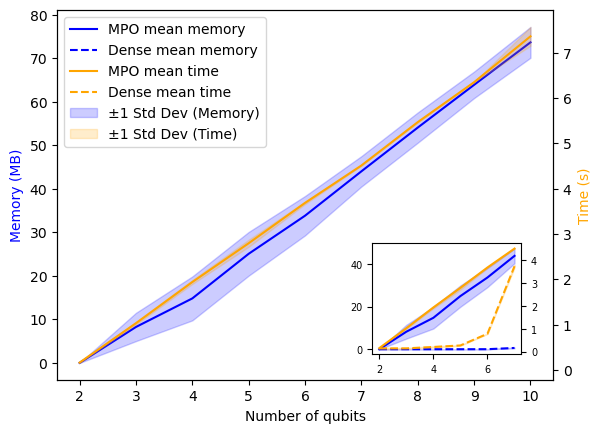

In [123]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
from collections import OrderedDict  # To remove duplicate labels in legend

fig, ax1 = plt.subplots()

# Create secondary y-axis
ax2 = ax1.twinx()

# === Main Plot (Only MPO Data) ===
ax1.plot(range(2, N+1), mean_values_memory_mpo, 'b-', label="MPO mean memory")  
ax2.plot(range(2, N+1), mean_values_time_mpo, 'orange', linestyle='-', label="MPO mean time")

# Standard deviation shaded area (now included in legend)
std_mem = ax1.fill_between(range(2, N+1), mean_values_memory_mpo - std_values_memory_mpo, 
                           mean_values_memory_mpo + std_values_memory_mpo, color="blue", alpha=0.2)
std_time = ax2.fill_between(range(2, N+1), mean_values_time_mpo - std_values_time_mpo, 
                            mean_values_time_mpo + std_values_time_mpo, color="orange", alpha=0.2)

# Labels for main plot
ax1.set_xlabel('Number of qubits')
ax1.set_ylabel('Memory (MB)', color='blue')
ax2.set_ylabel('Time (s)', color='orange')

# === Inset Plot (Moved Slightly Up and Left) ===
# Adjust `bbox_to_anchor` to move the inset inside the plot but away from axes
ax_inset1 = inset_axes(ax1, width="30%", height="30%", loc="lower right", 
                        bbox_to_anchor=(-0.05, 0.05, 1, 1), bbox_transform=ax1.transAxes)

# Create secondary y-axis for the inset
ax_inset2 = ax_inset1.twinx()


# MPO data in inset
ax_inset1.plot(range(2, N_dense+1), mean_values_memory_mpo[:N_dense-1], 'b-', label="MPO mean memory")  
ax_inset2.plot(range(2, N_dense+1), mean_values_time_mpo[:N_dense-1], 'orange', linestyle='-', label="MPO mean time")
ax_inset1.fill_between(range(2, N_dense+1), mean_values_memory_mpo[:N_dense-1] - std_values_memory_mpo[:N_dense-1], 
                       mean_values_memory_mpo[:N_dense-1] + std_values_memory_mpo[:N_dense-1], color="blue", alpha=0.2)
ax_inset2.fill_between(range(2, N_dense+1), mean_values_time_mpo[:N_dense-1] - std_values_time_mpo[:N_dense-1], 
                       mean_values_time_mpo[:N_dense-1] + std_values_time_mpo[:N_dense-1], color="orange", alpha=0.2)

# Dense data in inset
ax_inset1.plot(range(2, N_dense+1), mean_values_memory_dense, 'b--', label="Dense mean memory")  
ax_inset2.plot(range(2, N_dense+1), mean_values_time_dense, 'orange', linestyle='--', label="Dense mean time")
ax_inset1.fill_between(range(2, N_dense+1), mean_values_memory_dense - std_values_memory_dense, 
                       mean_values_memory_dense + std_values_memory_dense, color="blue", alpha=0.2)
ax_inset2.fill_between(range(2, N_dense+1), mean_values_time_dense - std_values_time_dense, 
                       mean_values_time_dense + std_values_time_dense, color="orange", alpha=0.2)

# Set labels for inset
ax_inset1.tick_params(axis='both', which='major', labelsize=7)
ax_inset2.tick_params(axis='both', which='major', labelsize=7)

# === Unified Legend  ===
handles_main, labels_main = ax1.get_legend_handles_labels()
handles_inset, labels_inset = ax_inset1.get_legend_handles_labels()

# Include standard deviation areas in legend
handles_combined = handles_main + handles_inset + [std_mem, std_time]
labels_combined = labels_main + labels_inset + ["±1 Std Dev (Memory)", "±1 Std Dev (Time)"]

# Remove duplicate labels
by_label = OrderedDict(zip(labels_combined, handles_combined))

# Place the legend in the upper left of the main plot
ax1.legend(by_label.values(), by_label.keys(), loc="upper left")

# Save and show plot
plt.savefig("Time_memory_mpo_ising.png", dpi=300, bbox_inches="tight")